In [1]:
import json, csv
import numpy as np
import pandas as pd

df = pd.read_csv('../datasets/entities_nlp_train_hongyu.csv')
df[20:30:2]

,id,keyword,location,text,entities,labels,ent_dep,ent_head,ent_pos,ent_children,target
20,31,missing,unknown,this is ridiculous....,None,None,None,None,None,None,0
22,33,missing,unknown,Love skiing,None,None,None,None,None,None,0
24,36,missing,unknown,LOOOOOOL,None,None,None,None,None,None,0
26,38,missing,unknown,Was in NYC last week!,"NYC,last week","ORG,DATE",pobj,in,ADP,None,0
28,40,missing,unknown,Cooool :),None,None,None,None,None,None,0


## evaluation

In [2]:
y = df['target']
y.shape

(7613,)

In [3]:
X = df.drop(['target'], axis=1)
X.columns

Index(['id', 'keyword', 'location', 'text', 'entities', 'labels', 'ent_dep',
       'ent_head', 'ent_pos', 'ent_children'],
      dtype='object')

In [18]:
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer

class LabeledNormalizer(Normalizer):
    def fit(self, X, *args, **kwargs):
        try:
            self.names = X.columns
        except:
            self.names = [str(i) for i in range(X.shape[1])]
        return super().fit(X, *args, **kwargs)
         
    def get_feature_names(self):
        return self.names
    
vec = ColumnTransformer([
#     ('norm', LabeledNormalizer(), ['id']),
    ('kw', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'keyword'),
    ('loc', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'location'),
    ('text', TfidfVectorizer(ngram_range=(1, 3), min_df=2, token_pattern=r"(?u)\b\w+\b"), 'text'),
    ('ent', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'entities'),
    ('label', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'labels'),
    ('dep', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_dep'),
    ('head', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_head'),
    ('pos', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_pos'),
    ('child', CountVectorizer(ngram_range=(1, 1), analyzer='word', token_pattern=r"(?u)\b\w+\b"), 'ent_children'),
    
])

# from sklearn.svm import LinearSVC
# from sklearn.svm import SVC
# clf = SVC(kernel='linear', probability=True)
# clf = SVC(kernel='rbf', probability=True)
# clf = SVC(kernel='poly', probability=True)
# clf = LinearSVC(verbose=True)

from sklearn.ensemble import RandomForestClassifier
# clf = RandomForestClassifier(n_estimators=20, random_state=0) # use a guassian forest
clf = RandomForestClassifier(n_estimators=200, random_state=0)
# clf = RandomForestClassifier(n_estimators=500, random_state=0) # parallel all jobs


pipeline = make_pipeline(vec, clf)

## feature importance (excluding text)

In [19]:
pipeline.fit(X, y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('kw',
                                                  CountVectorizer(analyzer='word',
                                                                  binary=False,
                                                                  decode_error='strict',
                                                                  dtype=<class 'numpy.int64'>,
                                                                  encoding='utf-8',
                                                                  input='content',
                                                                  lowercase=True,
                                                                  max_df=1.0,
                          

In [23]:
feature_imp = pd.Series(pipeline[1].feature_importances_,index=pipeline[0].get_feature_names()).sort_values(ascending=False)

In [24]:
# feature_imp[:10].plot(kind='bar')
feature_imp.shape

(40445,)

## Exclude text features

No handles with labels found to put in legend.


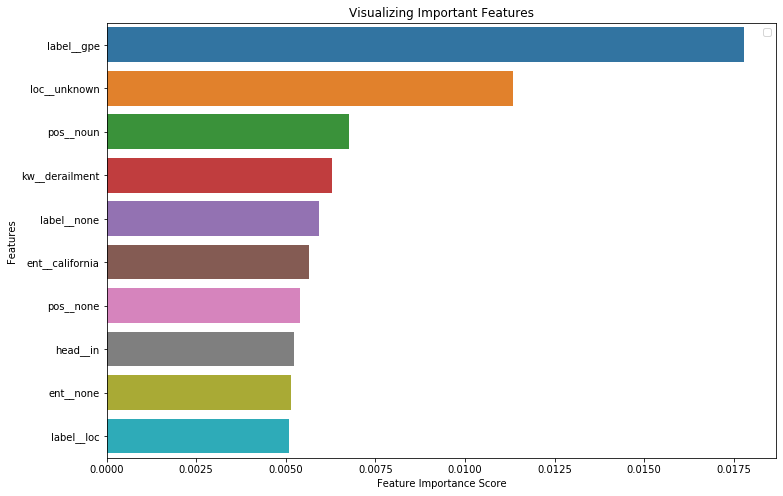

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Including text features

No handles with labels found to put in legend.


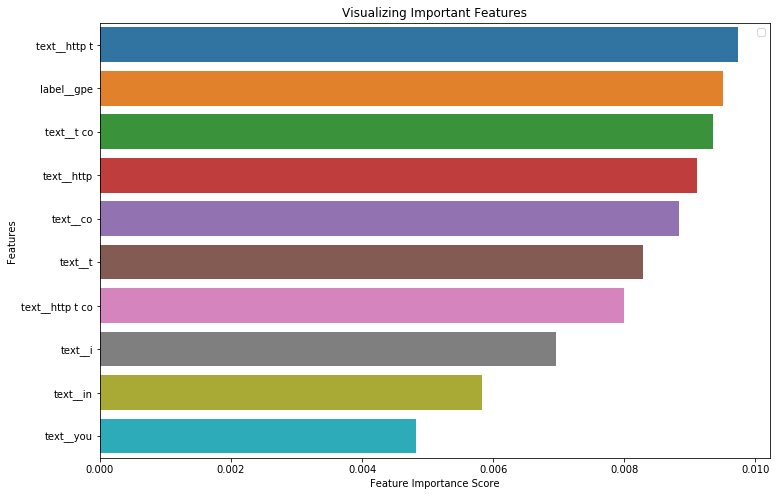

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)

F = plt.gcf()
Size = F.get_size_inches()
F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict

def evaluate(_clf, X, y):
    report = classification_report(
        y_true=y, y_pred=cross_val_predict(pipeline, X, y, cv=5)
    )
    print(report)
    scores = cross_val_score(_clf, X, y, scoring='accuracy', cv=5)
    print('Cross-validation MSE: {:.3f} ± {:.3f}'.format(np.mean(scores), 2 * np.std(scores)))
    
    _clf.fit(X,y)
    print('Training Set Accuracy: {:.3f}'.format(_clf.score(X,y)))


import time
start_time = time.time()

evaluate(pipeline, X, y)

seconds = time.time() - start_time
print('\nEvaluation Time Taken: ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

import time
start_time = time.time()

pipeline.fit(X,y)

seconds = time.time() - start_time
print('Training Time Taken:  ', time.strftime("%H:%M:%S",time.gmtime(seconds)))

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4342
           1       0.76      0.40      0.53      3271

    accuracy                           0.69      7613
   macro avg       0.72      0.65      0.65      7613
weighted avg       0.71      0.69      0.66      7613

Cross-validation MSE: 0.690 ± 0.067
Training Set Accuracy: 0.996

Evaluation Time Taken:  00:05:16
Training Time Taken:   00:00:39


## random forest

### 200 trees (excluding text features)
```
              precision    recall  f1-score   support

           0       0.63      0.82      0.71      4342
           1       0.61      0.36      0.45      3271

    accuracy                           0.63      7613
   macro avg       0.62      0.59      0.58      7613
weighted avg       0.62      0.63      0.60      7613

Cross-validation MSE: 0.625 ± 0.082
Training Set Accuracy: 0.976

Evaluation Time Taken:  00:04:20
Training Time Taken:   00:00:33
```

### 500 trees (original features):
```
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4342
           1       0.76      0.40      0.52      3271

    accuracy                           0.69      7613
   macro avg       0.71      0.65      0.65      7613
weighted avg       0.71      0.69      0.66      7613

Cross-validation MSE: 0.689 ± 0.062
Training Set Accuracy: 0.995

Evaluation Time Taken:  00:12:53
Training Time Taken:   00:01:37
```

### 200 trees (original 40k features):
```
              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4342
           1       0.77      0.41      0.53      3271

    accuracy                           0.69      7613
   macro avg       0.72      0.66      0.65      7613
weighted avg       0.71      0.69      0.67      7613

Cross-validation MSE: 0.692 ± 0.066
Training Set Accuracy: 0.995

Evaluation Time Taken:  00:05:43
Training Time Taken:   00:00:45
```

(use counter vectorizer)
```

              precision    recall  f1-score   support

           0       0.67      0.91      0.77      4342
           1       0.76      0.40      0.53      3271

    accuracy                           0.69      7613
   macro avg       0.72      0.65      0.65      7613
weighted avg       0.71      0.69      0.66      7613

Cross-validation MSE: 0.690 ± 0.067
Training Set Accuracy: 0.996

Evaluation Time Taken:  00:05:16
Training Time Taken:   00:00:39
```

### 20 trees (original features):
```
              precision    recall  f1-score   support

           0       0.66      0.90      0.76      4342
           1       0.75      0.39      0.51      3271

    accuracy                           0.68      7613
   macro avg       0.71      0.65      0.64      7613
weighted avg       0.70      0.68      0.66      7613

Cross-validation MSE: 0.682 ± 0.060
Training Set Accuracy: 0.987

Evaluation Time Taken:  00:00:49
Training Time Taken:   00:00:05
```

# Conclusion:
1. Test features are useful;

In [16]:
from sklearn.externals import joblib

pipeline.fit(X, y)

rf_mdl = '../models/random-forest-200.pkl'
joblib.dump(pipeline, rf_mdl)
!ls -lSh $rf_mdl

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


-rw-r--r-- 1 hongyu hongyu 64M Mar 26 00:48 ../models/random-forest-200.pkl
